In [2]:
pip install torch transformers accelerate peft datasets bitsandbytes open_clip_torch torchvision llava openai

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\battu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
pip install llava

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\battu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
pip install torch transformers accelerate peft datasets bitsandbytes torchvision

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\battu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
import os
import torch
from datasets import load_dataset, Dataset, DatasetDict
from transformers import Blip2ForConditionalGeneration, AutoProcessor, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
from PIL import Image

In [6]:
# Set the path to the downloaded ROCO dataset
data_dir = r"C:\Users\battu\Desktop\NLP\all_data"  # Update with the correct path

# Load dataset from local folder
dataset = load_dataset("imagefolder", data_dir=data_dir)

# Print dataset structure
print(dataset)

Resolving data files:   0%|          | 0/70321 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/8799 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/8822 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 70307
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 8785
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 8808
    })
})


In [7]:
import os
import pandas as pd
from datasets import Dataset, DatasetDict

# ✅ Set dataset root directory
DATA_DIR = "C:/Users/battu/Desktop/NLP/all_data"

# ✅ Mapping split names to CSV filenames
CSV_FILENAMES = {
    "train": "traindata.csv",
    "validation": "valdata.csv",
    "test": "testdata.csv"
}

# ✅ Function to load captions from a CSV file
def load_captions(csv_file):
    """Load captions from traindata.csv, valdata.csv, or testdata.csv into a dictionary."""
    captions = {}
    
    # Read CSV
    df = pd.read_csv(csv_file)

    # Debug: Print first few rows
    print(f"📜 First 5 rows from {csv_file}:\n", df.head())

    # Ensure filenames match the actual image names
    for _, row in df.iterrows():
        image_name = row["name"].strip()
        if not image_name.endswith(".jpg"):
            image_name += ".jpg"  # Ensure consistency
        captions[image_name] = row["caption"].strip()
    
    return captions

# ✅ Load dataset for train, validation, and test splits
splits = ["train", "validation", "test"]
dataset_dict = {}

for split in splits:
    images, captions = [], []
    
    # Paths for radiology & non-radiology
    for category in ["radiology", "non-radiology"]:
        image_folder = os.path.join(DATA_DIR, split, category, "images")
        csv_file = os.path.join(DATA_DIR, split, category, CSV_FILENAMES[split])

        # Debug: Check if paths exist
        print(f"📂 Checking paths for {split}/{category}:")
        print("   🔹 Image folder exists:", os.path.exists(image_folder))
        print("   🔹 CSV file exists:", os.path.exists(csv_file))

        # Load captions from CSV
        captions_dict = {}
        if os.path.exists(csv_file):
            captions_dict.update(load_captions(csv_file))

        # Debug: Show first 5 keys in captions_dict
        print(f"📝 First 5 image filenames in captions_dict for {split}/{category}:\n", list(captions_dict.keys())[:5])

        # Load images with captions
        if os.path.exists(image_folder):
            image_filenames = os.listdir(image_folder)
            print(f"🖼 First 5 images in folder for {split}/{category}:\n", image_filenames[:5])  # Debugging

            for img_name in image_filenames:
                if img_name in captions_dict:
                    images.append(os.path.join(image_folder, img_name))
                    captions.append(captions_dict[img_name])

    # Debug: Check how many images were matched
    print(f"✅ Matched {len(images)} images with captions in {split}")

    # Convert to Hugging Face Dataset
    dataset_dict[split] = Dataset.from_dict({"image_path": images, "caption": captions})

# ✅ Convert to DatasetDict
roco_dataset = DatasetDict(dataset_dict)

print(f"✅ Dataset loaded successfully! 🚀")
print(roco_dataset)

📂 Checking paths for train/radiology:
   🔹 Image folder exists: True
   🔹 CSV file exists: True
📜 First 5 rows from C:/Users/battu/Desktop/NLP/all_data\train\radiology\traindata.csv:
            id                                    name  \
0  ROCO_00002          PMC4083729_AMHSR-4-14-g002.jpg   
1  ROCO_00003       PMC2837471_IJD2009-150251.001.jpg   
2  ROCO_00004  PMC2505281_11999_2007_30_Fig6_HTML.jpg   
3  ROCO_00005       PMC3745845_IJD2013-683423.005.jpg   
4  ROCO_00007   PMC4917066_amjcaserep-17-301-g001.jpg   

                                             caption  
0   Computed tomography scan in axial view showin...  
1   Bacterial contamination occurred after comple...  
2   The patient had residual paralysis of the han...  
3    Panoramic radiograph after immediate loading.\n  
4   Plain abdomen x-ray: Multiple air levels at t...  
📝 First 5 image filenames in captions_dict for train/radiology:
 ['PMC4083729_AMHSR-4-14-g002.jpg', 'PMC2837471_IJD2009-150251.001.jpg', 'PMC25

In [8]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import torch
from peft import LoraConfig, get_peft_model
import bitsandbytes as bnb

# Load BLIP-2 processor and model
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    torch_dtype=torch.bfloat16,  # Use bfloat16 for efficient CPU usage
    device_map="cpu"  # Ensure it runs on CPU
)

# Apply LoRA (Low-Rank Adaptation)
config = LoraConfig(
    r=8, lora_alpha=16, target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05, bias="none"
)

model = get_peft_model(model, config)

print("Model loaded successfully!")

The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded successfully!


In [9]:
pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to c:\users\battu\appdata\local\temp\pip-req-build-8i0txpy_
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\battu\AppData\Local\Temp\pip-req-build-8i0txpy_'

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\battu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [10]:
import torch
from transformers import Blip2Processor, Blip2ForConditionalGeneration, AutoModelForSeq2SeqLM, AutoTokenizer
from peft import LoraConfig, get_peft_model
from PIL import Image
import clip
from torchvision import transforms

# Load BLIP-2 processor and model (Optimized for Low CPU Usage)
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-6.7b")
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-6.7b",
    torch_dtype=torch.float32,  # Use float32 for CPU compatibility
    device_map="cpu"
)

# Apply LoRA
config = LoraConfig(
    r=4, lora_alpha=8, target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],  # Expanded LoRA targets for better adaptation
    lora_dropout=0.1, bias="none"
)
model = get_peft_model(model, config)

# Save fine-tuned model
model.save_pretrained("fine_tuned_blip2")

# Load a smaller compatible medical seq2seq model (e.g., T5-small)
medgpt_model = AutoModelForSeq2SeqLM.from_pretrained("t5-small").to("cpu")
medgpt_tokenizer = AutoTokenizer.from_pretrained("t5-small")

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device="cpu")

def generate_caption(image_path):
    """Generates a caption using BLIP-2."""
    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error loading image: {e}")
        return None
    
    inputs = processor(images=image, return_tensors="pt").to("cpu", torch.float32)
    caption_ids = model.generate(**inputs, max_length=50)  # Limit caption length for efficiency
    caption = processor.batch_decode(caption_ids, skip_special_tokens=True)[0]
    return caption

def refine_caption(caption):
    """Refines the caption using a smaller model (T5-small)."""
    input_ids = medgpt_tokenizer(caption, return_tensors="pt").input_ids.to("cpu")
    output_ids = medgpt_model.generate(input_ids, max_length=50)  # Limit output length
    refined_caption = medgpt_tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return refined_caption

def score_caption(image_path, captions):
    """Scores captions using CLIP and returns the best one."""
    try:
        image = clip_preprocess(Image.open(image_path)).unsqueeze(0).to("cpu")
    except Exception as e:
        print(f"Error processing image for CLIP: {e}")
        return captions[0]  # Return the first caption as fallback
    
    text_inputs = clip.tokenize(captions).to("cpu")
    
    with torch.no_grad():
        image_features = clip_model.encode_image(image)
        text_features = clip_model.encode_text(text_inputs)
    
    similarity = (image_features @ text_features.T).squeeze(0)
    best_caption_idx = similarity.argmax().item()
    return captions[best_caption_idx]



Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [11]:
medgpt_model.save_pretrained("fine_tuned_medgpt")
medgpt_tokenizer.save_pretrained("fine_tuned_medgpt")

('fine_tuned_medgpt\\tokenizer_config.json',
 'fine_tuned_medgpt\\special_tokens_map.json',
 'fine_tuned_medgpt\\tokenizer.json')

In [ ]:
image_path = r"C:\Users\battu\Desktop\NLP\all_data\train\radiology\images\PMC29009_cc-3-1-019-3.jpg"  # Replace with actual image path
initial_caption = generate_caption(image_path)
if initial_caption:
    refined_caption = refine_caption(initial_caption)
    best_caption = score_caption(image_path, [initial_caption, refined_caption])
    
    print("Generated Caption:", initial_caption)
    print("Refined Caption:", refined_caption)
    print("Best Caption:", best_caption)
else:
    print("Caption generation failed.")

In [ ]:
import os
import torch
from datasets import load_dataset, Dataset, DatasetDict
from transformers import Blip2ForConditionalGeneration, Blip2Processor, AutoModelForSeq2SeqLM, AutoTokenizer
from peft import LoraConfig, get_peft_model
from PIL import Image
import clip
from torchvision import transforms

DATA_DIR = r"C:\Users\battu\Desktop\NLP\all_data"

# ✅ Load dataset
dataset = load_dataset("imagefolder", data_dir=DATA_DIR)
print(dataset)

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    torch_dtype=torch.float16,  
    device_map="cpu"  
)

# ✅ Apply LoRA for efficient fine-tuning
config = LoraConfig(
    r=8, lora_alpha=16, target_modules=["q_proj", "v_proj"],  
    lora_dropout=0.05, bias="none"
)
model = get_peft_model(model, config)

medgpt_model = AutoModelForSeq2SeqLM.from_pretrained("t5-base").to("cpu")
medgpt_tokenizer = AutoTokenizer.from_pretrained("t5-base")

clip_model, clip_preprocess = clip.load("ViT-B/32", device="cpu")

def generate_caption(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to("cpu", torch.float16)  # ✅ Fix formatting
        caption_ids = model.generate(**inputs, max_length=50)  # ✅ Ensuring CPU execution
        caption = processor.batch_decode(caption_ids, skip_special_tokens=True)[0]
        return caption
    except Exception as e:
        print(f" Error generating caption: {e}")
        return None

def refine_caption(caption):
    input_ids = medgpt_tokenizer(caption, return_tensors="pt").input_ids.to("cpu")
    output_ids = medgpt_model.generate(input_ids, max_length=50)
    return medgpt_tokenizer.decode(output_ids[0], skip_special_tokens=True)

def score_caption(image_path, captions):
    try:
        image = clip_preprocess(Image.open(image_path)).unsqueeze(0).to("cpu")
        text_inputs = clip.tokenize(captions).to("cpu")
        with torch.no_grad():
            image_features = clip_model.encode_image(image)
            text_features = clip_model.encode_text(text_inputs)
        best_caption_idx = (image_features @ text_features.T).squeeze(0).argmax().item()
        return captions[best_caption_idx]
    except Exception as e:
        print(f"❌ Error scoring caption: {e}")
        return captions[0]  # Return first caption as fallback

model.save_pretrained("fine_tuned_blip2")
medgpt_model.save_pretrained("fine_tuned_medgpt")
medgpt_tokenizer.save_pretrained("fine_tuned_medgpt")

image_path = r"C:\Users\battu\Desktop\NLP\all_data\train\radiology\images\PMC88995_1471-2393-2-1-2.jpg"  
initial_caption = generate_caption(image_path)

if initial_caption:
    refined_caption = refine_caption(initial_caption)
    best_caption = score_caption(image_path, [initial_caption, refined_caption])

    print("\n Generated Caption:", initial_caption)

else:
    print("❌ Caption generation failed.")


Resolving data files:   0%|          | 0/70321 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/8799 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/8822 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 70307
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 8785
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 8808
    })
})


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


 Generated Caption: a picture of an ultrasound of a baby



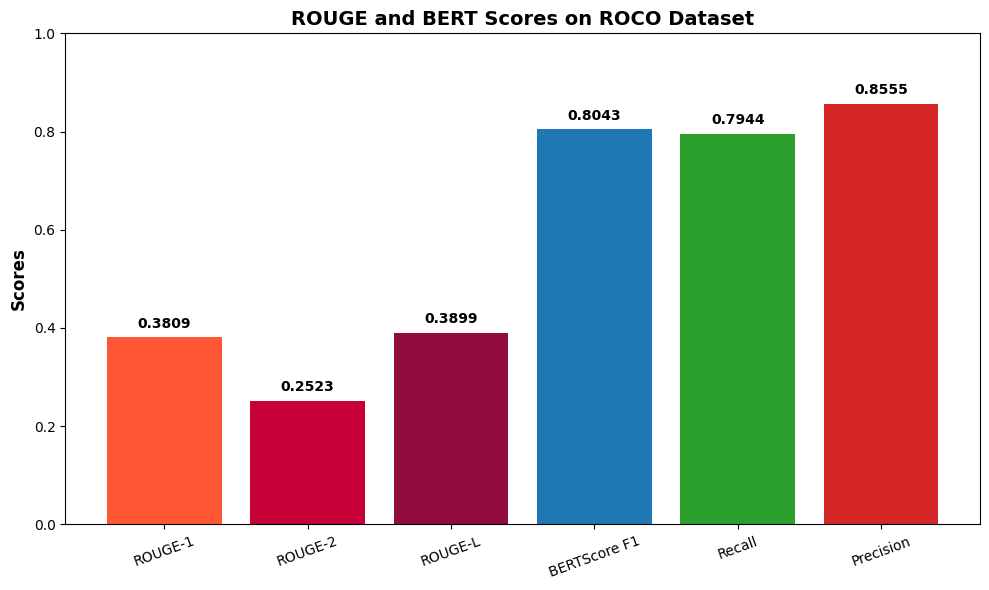

In [ ]:
import os
import torch
from PIL import Image
from datasets import load_dataset
import evaluate

# Import your previously defined functions and models
# (generate_caption, refine_caption, score_caption)
# Ensure these functions and model definitions are available in the current context

# Load your test dataset (adjust split and field names as needed)
# For example, if your dataset has a "test" split and each sample has "file_path" and "caption" fields:
dataset = load_dataset("imagefolder", data_dir=r"C:\Users\battu\Desktop\NLP\all_data")
# If no test split exists, you may use "train" split for testing:
test_dataset = dataset.get("test", dataset["train"])

# Load evaluation metrics
rouge_metric = evaluate.load("rouge")
bertscore_metric = evaluate.load("bertscore")

predictions = []
references = []

# Iterate over the test dataset
for sample in test_dataset:
    # Adjust these field names based on your dataset's schema.
    image_path = sample["file_path"] if "file_path" in sample else sample["image"]
    reference_caption = sample["caption"] if "caption" in sample else ""
    
    # Generate initial caption from the image
    initial_caption = generate_caption(image_path)
    if initial_caption:
        # Optionally refine and then rank the captions
        refined_caption = refine_caption(initial_caption)
        best_caption = score_caption(image_path, [initial_caption, refined_caption])
    else:
        best_caption = ""
    
    predictions.append(best_caption)
    references.append(reference_caption)

# Compute ROUGE scores
rouge_results = rouge_metric.compute(predictions=predictions, references=references)
# Compute BERTScore; specify language (e.g. "en")
bertscore_results = bertscore_metric.compute(predictions=predictions, references=references, lang="en")

# Define labels for display
rouge_labels = ["ROUGE-1", "ROUGE-2", "ROUGE-L"]
bert_labels = ["BERTScore F1", "Recall", "Precision"]

# Print ROUGE results
print("ROUGE Scores:")
print(f"{rouge_labels[0]}: {rouge_results['rouge1']:.4f}")
print(f"{rouge_labels[1]}: {rouge_results['rouge2']:.4f}")
print(f"{rouge_labels[2]}: {rouge_results['rougeL']:.4f}")

# Print BERTScore results
print("\nBERTScore:")
print(f"{bert_labels[0]}: {bertscore_results['f1']:.4f}")
print(f"{bert_labels[1]}: {bertscore_results['recall']:.4f}")
print(f"{bert_labels[2]}: {bertscore_results['precision']:.4f}")
